In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240325%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240325T113656Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D89a6963464dd986b23363c3f77c1836acf53bd7b723efee89e366d9a16b6e589fac29d9650e738155efe8e61a5a5e8aed60739542920956b5b990a58dddffc27a7051a19a570111bafe055fea37402c78ae894e95a10f5a94a1ca332306204494b2ecf19e90becf1a1133f86a8ac793cafa9c7636d5d61a88bcf1ccdee7c5ac5ad4892231a70bd39240c4da8fbd22041256e27934026e37114e2bd550f30c56f63ce09d786ffc3698c4ae9accc212150461fe6b440d2cb0c17bec07604ed9c8d7359eff45711a9c3761acc37e1a786c0eb2cfd6761d0d000ec9a21b30490357fc04f9077ffae56ee21d502e3bf791b50465581440bd0ae63d8d3228b35a8f93a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
Data source import complete.


# Twitter Sentiment Analysis - Classical Approach VS Deep Learning

# Introduction

# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [ ]:
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Reading the dataset with no columns titles and with latin encoding
df_raw = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["label", "time", "date", "query", "username", "text"]

# Show the first 5 rows of the dataframe.
# You can specify the number of rows to be shown as follows: df_raw.head(10)
df_raw.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Checking the data's output balance
# The label '4' denotes positive sentiment and '0' denotes negative sentiment
df_raw['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [ ]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['label', 'text']]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Separating positive and negative rows
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [ ]:
# Only retaining 1/4th of our data from each output group
# Feel free to alter the dividing factor depending on your workspace
# 1/64 is a good place to start if you're unsure about your machine's power
df_pos = df_pos.iloc[:int(len(df_pos)/4)]
df_neg = df_neg.iloc[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [ ]:
# Concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

400000

# 2. Cleaning and Processing the Data <a class="anchor" id="head-2"></a>

## 2.1. Tokenization <a class="anchor" id="head-2-1"></a>

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))

# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 47.712300300598145


[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'],
  1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'Cant',
   'wait',
   '!',
   '!',
   '-',
   'GIRL',
   'TALK',
   '!',
   '!'],
  1),
 (['@DaRealSunisaKim',
   'Thanks',
   'for',
   'the',
   'Twitter',
   'add',
   ',',
   'Sunisa',
   '!',
   'I',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'HIN',
   'show',
   'here',
   'in',
   'the',
   'DC',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['Being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'Plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

## 2.2. Lemmatization <a class="anchor" id="head-2-2"></a>

In [ ]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download("popular")

# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [ ]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['I', 'LOVE', '@Health4UandPets', 'u', 'guy', 'r', 'the', 'best', '!', '!']


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance.
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())

        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['love', 'guy', 'best']


In [ ]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))

print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]

Removed Noise, CPU Time: 313.4612822532654
Data Prepared for model, CPU Time: 1.7839889526367188


[({'love': True, 'guy': True, 'best': True}, 1),
 ({'meet': True,
   'one': True,
   'besties': True,
   'tonight': True,
   'cant': True,
   'wait': True,
   'girl': True,
   'talk': True},
  1),
 ({'thanks': True,
   'twitter': True,
   'add': True,
   'sunisa': True,
   'get': True,
   'meet': True,
   'hin': True,
   'show': True,
   'area': True,
   'sweetheart': True},
  1),
 ({'sick': True,
   'really': True,
   'cheap': True,
   'hurt': True,
   'much': True,
   'eat': True,
   'real': True,
   'food': True,
   'plus': True,
   'friend': True,
   'make': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

# 3. Visualizing the Data <a class="anchor" id="head-3"></a>

Positive words


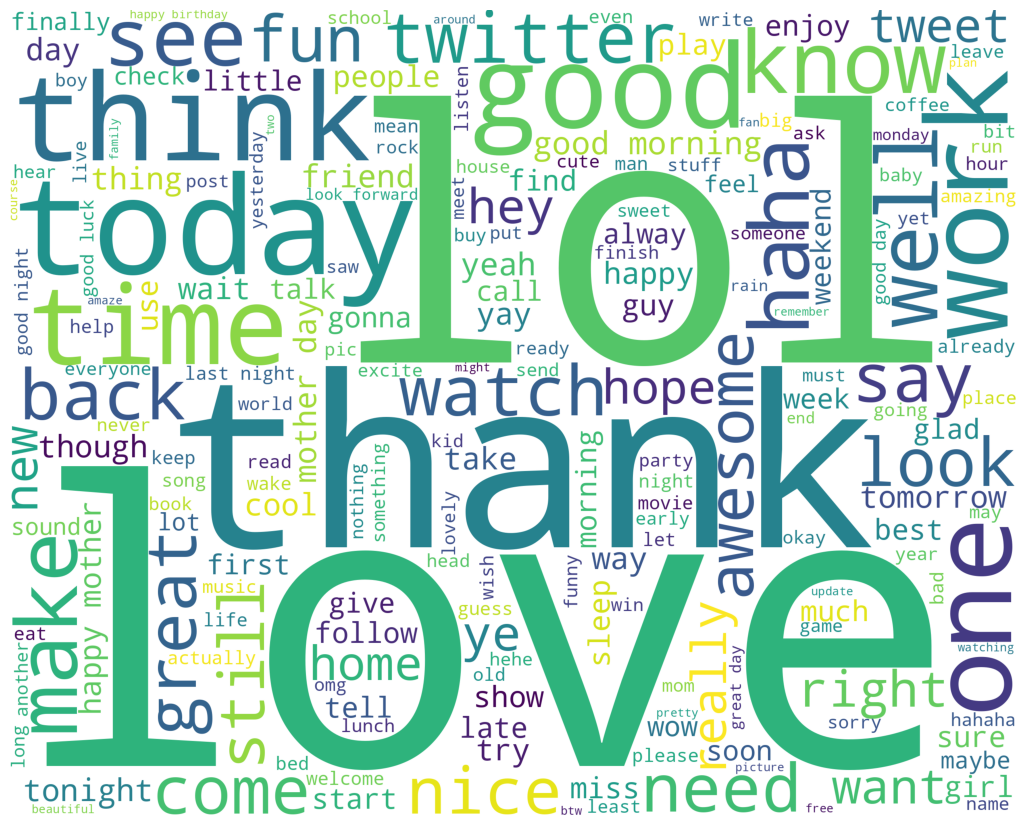

Negative words


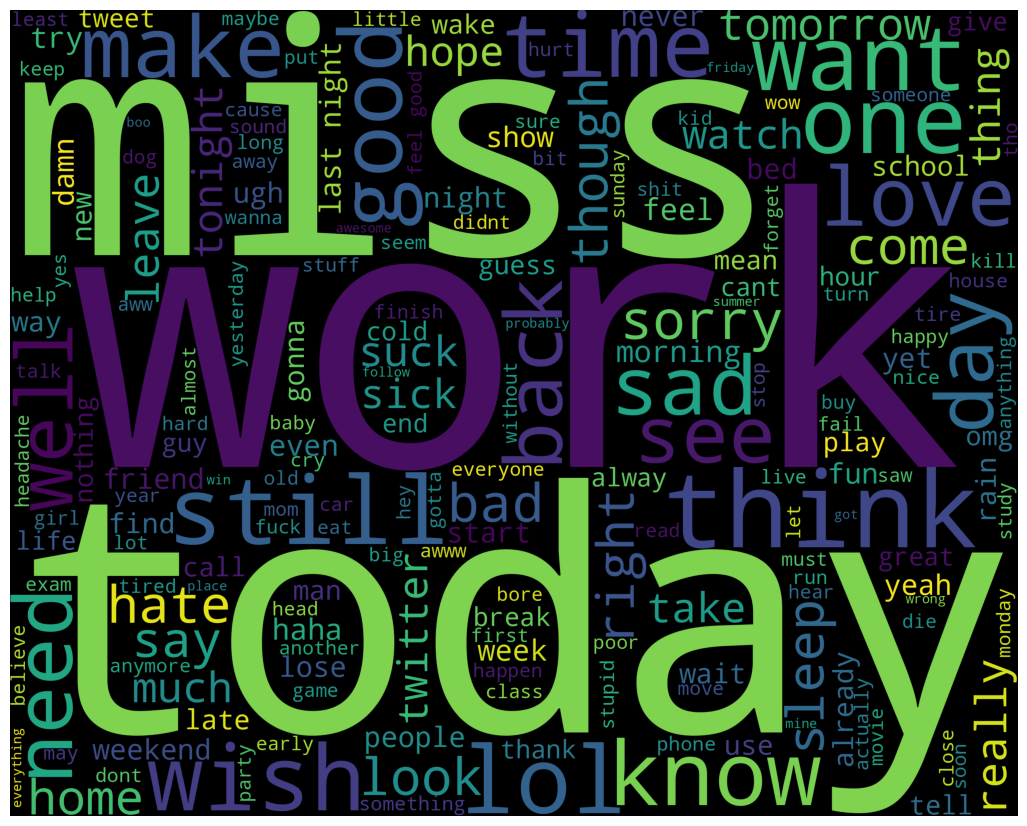

CPU Time: 37.44034194946289


In [ ]:
from wordcloud import WordCloud, STOPWORDS

start_time = time()

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)

print('CPU Time:', time() - start_time)

# 4. Naive Bayesian Model <a class="anchor" id="head-4"></a>

## 4.1. Splitting the Data <a class="anchor" id="head-4-1"></a>

In [ ]:
# As our data is currently ordered by label, we have to shuffle it before splitting it
# .Random(140) randomizes our data with seed = 140. This guarantees the same shuffling for every execution of our code
# Feel free to alter this value or even omit it to have different outputs for each code execution
random.Random(140).shuffle(final_data)

# Here we decided to split our data as 90% train data and 10% test data
# Once again, feel free to alter this number and test the model accuracy
trim_index = int(len(final_data) * 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

## 4.2. Training the Model <a class="anchor" id="head-4-2"></a>

In [ ]:
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Output the model accuracy on the train and test data
print('Accuracy on train data:', classify.accuracy(classifier, train_data))
print('Accuracy on test data:', classify.accuracy(classifier, test_data))

# Output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group.
print(classifier.show_most_informative_features(20))

print('\nCPU Time:', time() - start_time)

Accuracy on train data: 0.8107305555555555
Accuracy on test data: 0.755575
Most Informative Features
               depressed = True                0 : 1      =     49.0 : 1.0
               toothache = True                0 : 1      =     45.0 : 1.0
                    roni = True                0 : 1      =     34.3 : 1.0
                 unhappy = True                0 : 1      =     31.4 : 1.0
                   strep = True                0 : 1      =     31.0 : 1.0
                  asthma = True                0 : 1      =     26.3 : 1.0
                 unloved = True                0 : 1      =     25.0 : 1.0
                  #movie = True                1 : 0      =     23.0 : 1.0
                  gutted = True                0 : 1      =     22.3 : 1.0
                   hates = True                0 : 1      =     21.9 : 1.0
               heartburn = True                0 : 1      =     21.7 : 1.0
                     bom = True                1 : 0      =     21.4 : 1.0

## 4.3. Testing the Model <a class="anchor" id="head-4-3"></a>

In [ ]:
custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0


In [ ]:
custom_tweet = "I loved the show today! It was amazing."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [ ]:
custom_tweet = "No idea"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [ ]:
custom_tweet = "Good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [ ]:
custom_tweet = "Not good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Also, the model isn't robust against sarcastic sentences.

In [ ]:
custom_tweet = "The reward for good work is more work!"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


## 4.4. Asserting the Model <a class="anchor" id="head-4-4"></a>

Finally, let's further assert our model by plotting the AUC and the confusion matrix of the model.

In [ ]:
from sklearn import metrics

# Storing all desired values in a list
y = [test_data[i][1] for i in range(len(test_data))]
# Storing all probabilities of having a positive sentiment in a list
probs = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]

# Making sure both values a re equal
print(len(y), len(probs))

# performing the roc curve calculations
fpr, tpr, thresholds = metrics.roc_curve(y, probs)

# Printing the Area Under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

40000 40000
AUC: 0.834


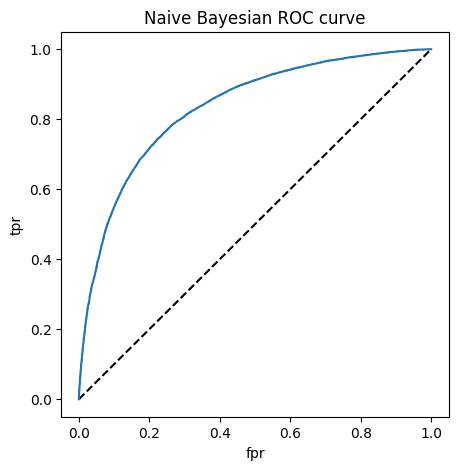

In [ ]:
# Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Naive Bayesian ROC curve')
plt.show()

In [ ]:
# Creating a confusion matrix (this specific confusion matrix function accepts numpy arrays rather than python lists)

probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,16529,3451,19980
1,6326,13694,20020
All,22855,17145,40000


# 5. Deep Learning Model - LSTM <a class="anchor" id="head-5"></a>

## 5.1. Data Pre-processing <a class="anchor" id="head-5-1"></a>

### 5.1.1. Word Embeddings <a class="anchor" id="head-5-1-1"></a>

### 5.1.2. Global Vectors for Word Representation (GloVe) <a class="anchor" id="head-5-1-2"></a>

In [ ]:
# Downloading and unzipping the glove word embeddings from the official website

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-03-25 17:52:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-25 17:52:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-25 17:52:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [ ]:
word_to_index['hello']

176468

In [ ]:
word_to_vec_map['hello']

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

In [ ]:
word_to_index['unk']

372306

In [ ]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['tomato'])

0.8632714714841137

In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.012485506721235957

## 5.2. Data Transformation <a class="anchor" id="head-5-2"></a>

In [ ]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index


# Here we will utilize the already computed 'cleaned_tokens_list' variable

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label

print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.00046634674072265625
max_len: 25
Data Prepared for model, CPU Time: 3.2626211643218994
[[226278. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 160418. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204. 286963.
  154049. 231458. 338210.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [133896. 141948.      0.      0.      0.      0.      0. 

## 5.3. Building the Model <a class="anchor" id="head-5-3"></a>

In [ ]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding


from sklearn.model_selection import train_test_split

In [ ]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [ ]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output betwene 0 and 1.

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            20000050  
                                                                 
 bidirectional (Bidirection  (None, 25, 256)           183296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 20577843 (78.50 MB)
Trainable params: 577793 (2.20 MB)
Non-trainable params: 20000050 (76.29 MB)
_________________________________________________________________


In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
len(X_train)

320000

In [ ]:
len(X_test)

80000

## 5.4. Training the Model <a class="anchor" id="head-5-4"></a>

In [ ]:
# Setting a batch size of 20 and training our model for 20 epochs

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 42s 14ms/step - loss: 0.5515 - accuracy: 0.7132 - val_loss: 0.5174 - val_accuracy: 0.7391
Epoch 2/20
2500/2500 [==============================] - 31s 12ms/step - loss: 0.5076 - accuracy: 0.7465 - val_loss: 0.4962 - val_accuracy: 0.7547
Epoch 3/20
2500/2500 [==============================] - 30s 12ms/step - loss: 0.4860 - accuracy: 0.7612 - val_loss: 0.4901 - val_accuracy: 0.7608
Epoch 4/20
2500/2500 [==============================] - 33s 13ms/step - loss: 0.4676 - accuracy: 0.7732 - val_loss: 0.4897 - val_accuracy: 0.7623
Epoch 5/20
2500/2500 [==============================] - 34s 14ms/step - loss: 0.4495 - accuracy: 0.7842 - val_loss: 0.4830 - val_accuracy: 0.7663
Epoch 6/20
2500/2500 [==============================] - 31s 12ms/step - loss: 0.4284 - accuracy: 0.7963 - val_loss: 0.4902 - val_accuracy: 0.7642
Epoch 7/20
2500/2500 [==============================] - 33s 13ms/step - loss: 0.4035 - accuracy: 0.8103 - val_loss: 0.5081 -

In [ ]:
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

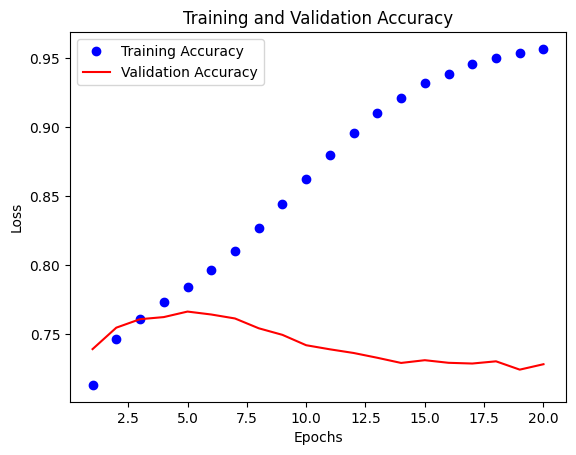

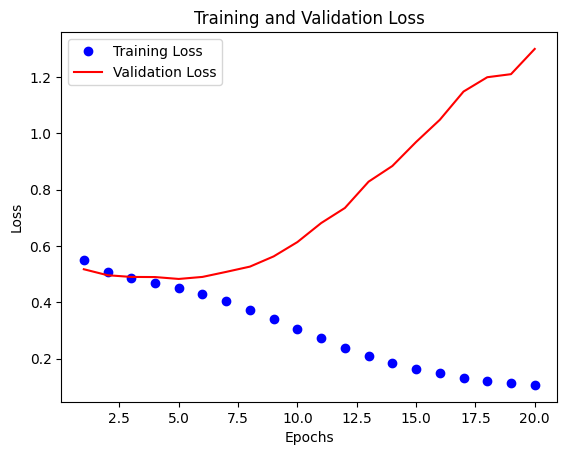

In [ ]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

The training accuracy is sky-rocketing, exceeding **95%** after 20 epochs! However, the validation accuracy increased slightly in the early epochs, reaching **76.7%** on the 5th epoch, after which it experienced a consistently gradual decrease. In data science, we would classify this model as having very high variance and low bias. This is also referred to as "over-fitting".

**Over-Fitting** is basically the phenomenon where the model's performance on validation data starts degrading, while still achieving great progress on the test set. In other words, the model is doing exceptionally well on learning specific examples it has been trained on, but is failing to generalize to data it never saw in its training phase.

## 5.5. Investigating Possibilties to Improve the Model <a class="anchor" id="head-5-5"></a>

### 5.5.1. Regularization - Dropout <a class="anchor" id="head-5-5-1"></a>

### Model Building - Dropout

In [ ]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            20000050  
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 bidirectional (Bidirection  (None, 25, 256)           183296    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training - Dropout

In [ ]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 44s 14ms/step - loss: 0.5957 - accuracy: 0.6750 - val_loss: 0.5359 - val_accuracy: 0.7273
Epoch 2/20
2500/2500 [==============================] - 34s 13ms/step - loss: 0.5633 - accuracy: 0.7025 - val_loss: 0.5198 - val_accuracy: 0.7396
Epoch 3/20
2500/2500 [==============================] - 31s 12ms/step - loss: 0.5492 - accuracy: 0.7144 - val_loss: 0.5130 - val_accuracy: 0.7413
Epoch 4/20
2500/2500 [==============================] - 31s 12ms/step - loss: 0.5391 - accuracy: 0.7215 - val_loss: 0.5007 - val_accuracy: 0.7519
Epoch 5/20
2500/2500 [==============================] - 35s 14ms/step - loss: 0.5326 - accuracy: 0.7262 - val_loss: 0.4969 - val_accuracy: 0.7544
Epoch 6/20
2500/2500 [==============================] - 31s 12ms/step - loss: 0.5272 - accuracy: 0.7317 - val_loss: 0.4946 - val_accuracy: 0.7569
Epoch 7/20
2500/2500 [==============================] - 33s 13ms/step - loss: 0.5226 - accuracy: 0.7344 - val_loss: 0.4912 -

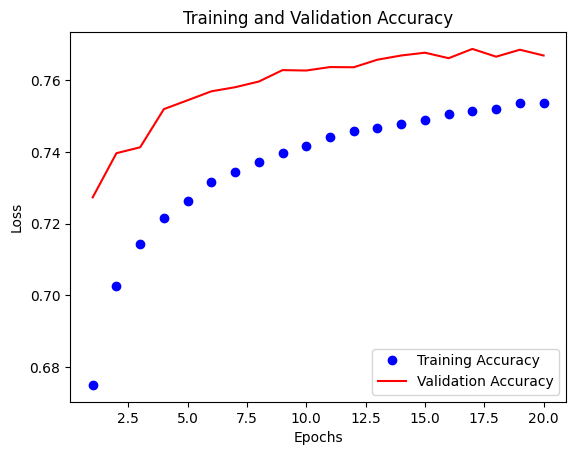

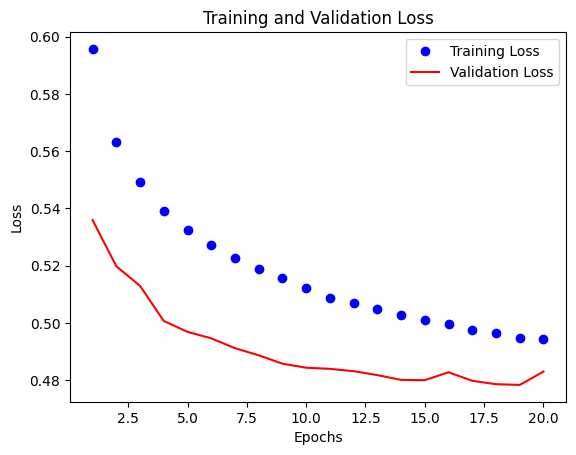

In [ ]:
plot_acc_loss(model_dropout.history)

In [ ]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 34s 14ms/step - loss: 0.4925 - accuracy: 0.7552 - val_loss: 0.4780 - val_accuracy: 0.7686
Epoch 2/20
2500/2500 [==============================] - 37s 15ms/step - loss: 0.4916 - accuracy: 0.7553 - val_loss: 0.4774 - val_accuracy: 0.7703
Epoch 3/20
2500/2500 [==============================] - 32s 13ms/step - loss: 0.4905 - accuracy: 0.7566 - val_loss: 0.4786 - val_accuracy: 0.7698
Epoch 4/20
2500/2500 [==============================] - 37s 15ms/step - loss: 0.4888 - accuracy: 0.7582 - val_loss: 0.4809 - val_accuracy: 0.7695
Epoch 5/20
2500/2500 [==============================] - 34s 14ms/step - loss: 0.4890 - accuracy: 0.7578 - val_loss: 0.4782 - val_accuracy: 0.7689
Epoch 6/20
2500/2500 [==============================] - 35s 14ms/step - loss: 0.4873 - accuracy: 0.7588 - val_loss: 0.4785 - val_accuracy: 0.7694
Epoch 7/20
2500/2500 [==============================] - 37s 15ms/step - loss: 0.4870 - accuracy: 0.7580 - val_loss: 0.4778 -

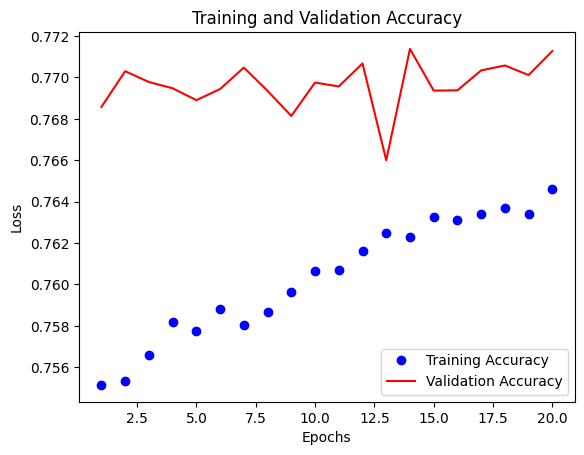

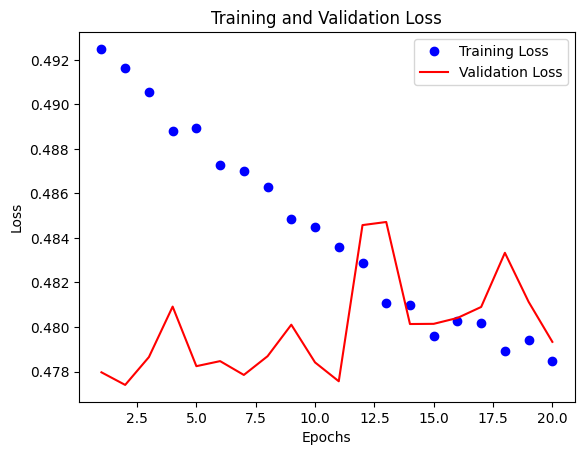

In [ ]:
plot_acc_loss(model_dropout.history)

### 5.5.2. Inspecting the Data - Unknown Words <a class="anchor" id="head-5-5-2"></a>

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

198378

In [ ]:
len(unks)

198378

In [ ]:
len(UNKS)

226552

In [ ]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 32149),
 ("can't", 11370),
 ("i'l", 6284),
 ("that's", 5478),
 ("i've", 5085),
 ("he's", 1976),
 ("mother's", 1878),
 ("i'd", 1855),
 ('hahaha', 1723),
 ("we're", 1578),
 ("there's", 1425),
 ("what's", 1356),
 ("they're", 1179),
 ('lmao', 1104),
 ("we'l", 914),
 ("let's", 802),
 ('bday', 618),
 ('. .', 600),
 ('idk', 588),
 ("it'l", 587),
 ('hahah', 486),
 ('. . .', 481),
 ("how's", 440),
 ("who's", 378),
 ('#fb', 358),
 ('hahahaha', 356),
 ("mom's", 333),
 ('#asot40', 333),
 (":'(", 327),
 ("ain't", 317),
 ("y'al", 313),
 ("we've", 312),
 ('tweps', 312),
 (';-)', 307),
 ('thanx', 290),
 ('coky', 289),
 ('#folowfriday', 266),
 ("today's", 264),
 ('hehehe', 259),
 ('awh', 259),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('b-day', 193),
 ('tomorow', 191),
 ("they'l", 191),
 ("ya'l", 187)]

### Further data cleaning

In [ ]:
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        cleaned_token = cleaned(token.lower())

        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation:
            cleaned_tokens.append(cleaned_token)

    return cleaned_tokens


# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['i', 'love', 'you', 'guys', 'are', 'the', 'best']


In [ ]:
start_time = time()

unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)


X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))


for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label

print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 30.592320919036865
max_len: 79
Data Prepared for model, CPU Time: 2.670267105102539
[[185457. 226278. 394475. 169754.  58997. 357266.  74390.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [187631. 239792. 373317. 388711. 269953. 268046. 254258. 372306. 361859.
   91041. 382320. 161844. 352214.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0. 

Great, let's take a look at the progress accomplished:

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

119802

In [ ]:
from collections import Counter
Counter(unks).most_common(50)

[(':/', 688),
 ('(:', 451),
 ('shouldnt', 429),
 ('. .', 397),
 ('#fb', 358),
 ('#asot40', 333),
 (":'(", 327),
 ('tweps', 312),
 (';-)', 307),
 ('->', 288),
 ('iï', 278),
 ('#folowfriday', 266),
 ("today's", 264),
 ('d:', 261),
 ('hehehe', 259),
 ('awh', 259),
 ("weren't", 257),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('tomorow', 191),
 ("they'l", 191),
 ('8:', 189),
 ('sux', 184),
 ('hadnt', 178),
 ('tmrw', 177),
 ('bleh', 174),
 ('retwet', 173),
 ('yey', 171),
 ('probs', 169),
 ('<-', 167),
 ('#delongeday', 167),
 ('theyve', 164),
 ('twiterverse', 160),
 ('awsome', 150),
 ("friend's", 148),
 ('lï', 146),
 ('itï', 142),
 ('cï', 139),
 ("everyone's", 138),
 ("g'night", 137),
 ('twiterland', 137),
 ('damnit', 137),
 ('omfg', 136),
 ("she'l", 135),
 ('=/', 134),
 ('proly', 134)]

### Model Training - Cleaner Data

In [ ]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 50)            20000050  
                                                                 
 bidirectional (Bidirection  (None, 79, 256)           183296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 20577843 (78.50 MB)
Trainable params: 577793 (2.20 MB)
Non-trainable params: 20000050 (76.29 MB)
_________________________________________________________________


In [ ]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
len(X_train)

319360

In [ ]:
len(X_test)

79841

In [ ]:
model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2495/2495 [==============================] - 79s 28ms/step - loss: 0.5223 - accuracy: 0.7362 - val_loss: 0.4689 - val_accuracy: 0.7743
Epoch 2/20
2495/2495 [==============================] - 72s 29ms/step - loss: 0.4544 - accuracy: 0.7839 - val_loss: 0.4386 - val_accuracy: 0.7940
Epoch 3/20
2495/2495 [==============================] - 72s 29ms/step - loss: 0.4249 - accuracy: 0.8023 - val_loss: 0.4258 - val_accuracy: 0.8022
Epoch 4/20
2495/2495 [==============================] - 67s 27ms/step - loss: 0.4025 - accuracy: 0.8151 - val_loss: 0.4196 - val_accuracy: 0.8063
Epoch 5/20
2495/2495 [==============================] - 72s 29ms/step - loss: 0.3811 - accuracy: 0.8272 - val_loss: 0.4208 - val_accuracy: 0.8077
Epoch 6/20
2495/2495 [==============================] - 72s 29ms/step - loss: 0.3586 - accuracy: 0.8391 - val_loss: 0.4245 - val_accuracy: 0.8090
Epoch 7/20
2495/2495 [==============================] - 73s 29ms/step - loss: 0.3328 - accuracy: 0.8528 - val_loss: 0.4374 -

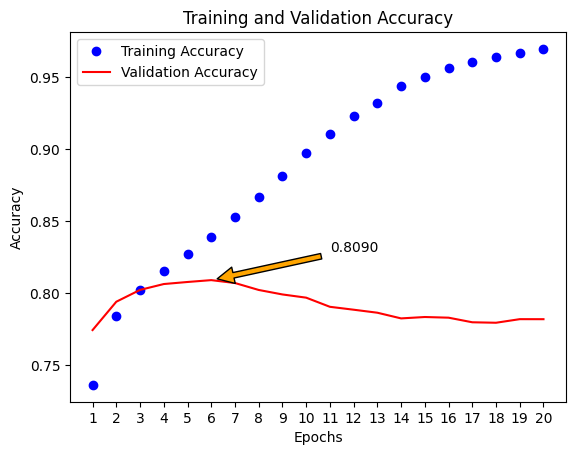

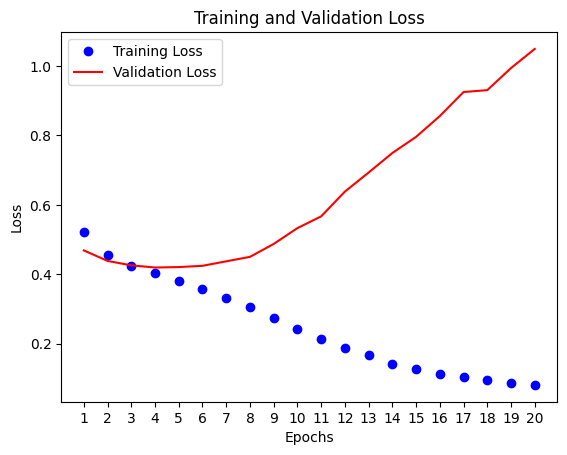

In [ ]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

The model managed to reach an impressive **81.1%** validation accuracy on the 5th epoch!


## 5.6. Predicting on Custom Data <a class="anchor" id="head-5-6"></a>

In [ ]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)

    # Retrun the model's prediction
    return model_clean_data.predict(np.array([x_input])).item()

In [ ]:
predict_custom_tweet_sentiment("I'm happy you're here!")

1/1 [==============================] - 1s 1s/step


0.9999995231628418

In [ ]:
predict_custom_tweet_sentiment("I'm not happy you're here!")

1/1 [==============================] - 0s 21ms/step


0.12693826854228973

In [ ]:
predict_custom_tweet_sentiment("I disliked his attitude...")

1/1 [==============================] - 0s 23ms/step


0.0025918311439454556

In [ ]:
predict_custom_tweet_sentiment("I'm infatuated with you")

1/1 [==============================] - 0s 22ms/step


0.15062826871871948

In [ ]:
(negative_words + positive_words).count('love')

17636

In [ ]:
(negative_words + positive_words).count('infatuated')

0

## 5.7. Inspecting Wrongly Predicted Data <a class="anchor" id="head-5-7"></a>

Let's take a look at some of the wrongly classified data from the model.

In [ ]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [ ]:
C = 0

pred = model_clean_data.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0

    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1

    if C > 100:
        break

2496/2496 [==============================] - 18s 7ms/step
Expected sentiment: 1. Input: rusty is back 
Expected sentiment: 1. Input: populating an online shop with home automation goodies 
Expected sentiment: 1. Input: work is done off for a beer 
Expected sentiment: 1. Input: like get off your bums and stop watching lousy daytime tv 
Expected sentiment: 0. Input: you sure i can if you want to because i want to and lol fish fish it actually really healthy silly its good for you so eat 
Expected sentiment: 0. Input: ahhh this sunshine needs taking advantage of damn work deeper than rap baby big unk album rick ross all day unk bun 50 
Expected sentiment: 0. Input: unk you get tht from 
Expected sentiment: 1. Input: it is working for me 
Expected sentiment: 0. Input: cool thanks shd check apple ones but i still unk find a maemo unk player with an equalizer gonna check xms now 
Expected sentiment: 1. Input: has made it to work on time fun times answering those phones 
Expected sentiment: 0

# 6. Analysing over a interval of time <a class="anchor" id="head-6"></a>

In [ ]:
# Taking only the label and the date in order to work on them
df_date = df_raw.copy()[['label', 'date']]
df_date.head()

,label,date
0,0,Mon Apr 06 22:19:45 PDT 2009
1,0,Mon Apr 06 22:19:49 PDT 2009
2,0,Mon Apr 06 22:19:53 PDT 2009
3,0,Mon Apr 06 22:19:57 PDT 2009
4,0,Mon Apr 06 22:19:57 PDT 2009


In [ ]:
# Adding a field to our dataframe, hour, containing the hour in which the tweet was published
df_date['hour'] = df_date.date.apply(lambda x: x[11:13]).astype('int32')
df_date.head()

,label,date,hour
0,0,Mon Apr 06 22:19:45 PDT 2009,22
1,0,Mon Apr 06 22:19:49 PDT 2009,22
2,0,Mon Apr 06 22:19:53 PDT 2009,22
3,0,Mon Apr 06 22:19:57 PDT 2009,22
4,0,Mon Apr 06 22:19:57 PDT 2009,22


In [ ]:
# Adding a field to our dataframe, dow, containing the day of week in which the tweet was published
df_date['dow'] = df_date.date.apply(lambda x: x[:3]).astype('str')
df_date.head()

,label,date,hour,dow
0,0,Mon Apr 06 22:19:45 PDT 2009,22,Mon
1,0,Mon Apr 06 22:19:49 PDT 2009,22,Mon
2,0,Mon Apr 06 22:19:53 PDT 2009,22,Mon
3,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon
4,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon


In [ ]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each hour of the day
temporal_hour = pd.pivot_table(df_date, index='label', columns='hour', aggfunc='size', fill_value=0)
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,35582,30581,30171,31717,34946,37774,40076,42208,40166,36511,...,27077,28531,31594,29316,29422,31193,30102,36007,39018,39506
4,45283,44687,43820,42536,42049,40849,40776,41446,36121,30767,...,23303,22112,24126,22527,24063,26529,26957,32957,39310,45244


<Axes: xlabel='hour'>

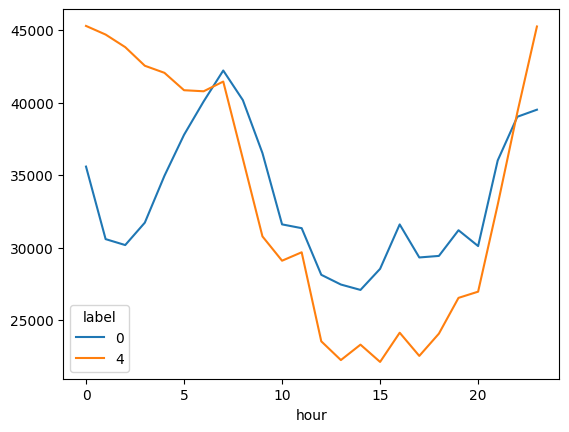

In [ ]:
# Plotting our results
temporal_hour.transpose().plot()

In [ ]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each hour of the day
temporal_hour = temporal_hour.iloc[:, :].apply(lambda x: x / x.sum())
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,0.440017,0.406295,0.407766,0.427148,0.453874,0.480445,0.495671,0.504554,0.526512,0.542689,...,0.537455,0.563375,0.567014,0.565477,0.550098,0.540401,0.527559,0.522113,0.498136,0.466147
4,0.559983,0.593705,0.592234,0.572852,0.546126,0.519555,0.504329,0.495446,0.473488,0.457311,...,0.462545,0.436625,0.432986,0.434523,0.449902,0.459599,0.472441,0.477887,0.501864,0.533853


<Axes: xlabel='hour'>

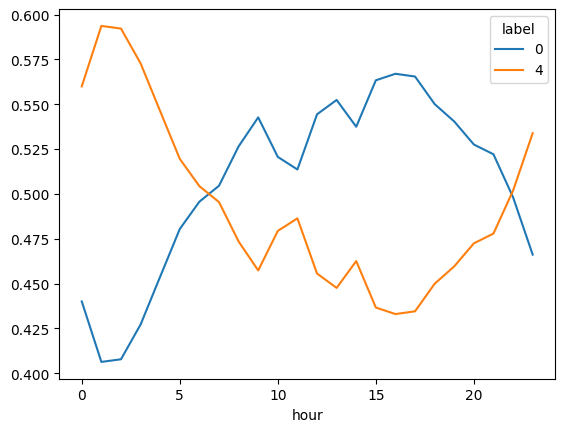

In [ ]:
# Plotting our results
temporal_hour.transpose().plot()

In [ ]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each day of the week
temporal_dow = pd.pivot_table(df_date, index='label', columns='dow', aggfunc='size', fill_value=0)
temporal_dow

dow,Fri,Mon,Sat,Sun,Thu,Tue,Wed
label,,,,,,,
0,114600,132539,157734,145471,80132,101051,68473
4,110994,177666,173221,199084,25903,84799,28333


In [ ]:
# Re-ordering our table
temporal_dow = temporal_dow[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,132539,101051,68473,80132,114600,157734,145471
4,177666,84799,28333,25903,110994,173221,199084


<Axes: xlabel='dow'>

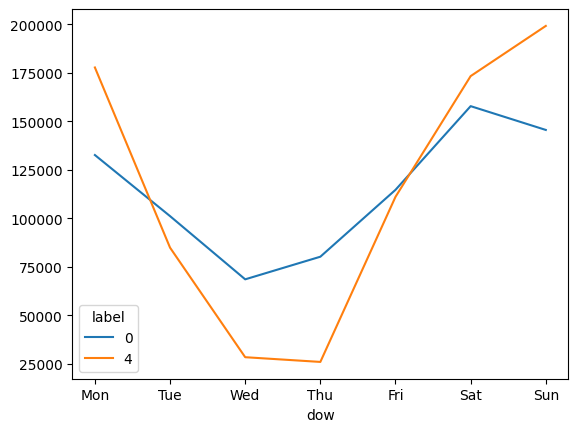

In [ ]:
# Plotting our results
temporal_dow.transpose().plot()

In [ ]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each day of the week
temporal_dow = temporal_dow.iloc[:, :].apply(lambda x: x / x.sum())
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,0.427263,0.543723,0.707322,0.755713,0.507992,0.476603,0.4222
4,0.572737,0.456277,0.292678,0.244287,0.492008,0.523397,0.5778


<Axes: xlabel='dow'>

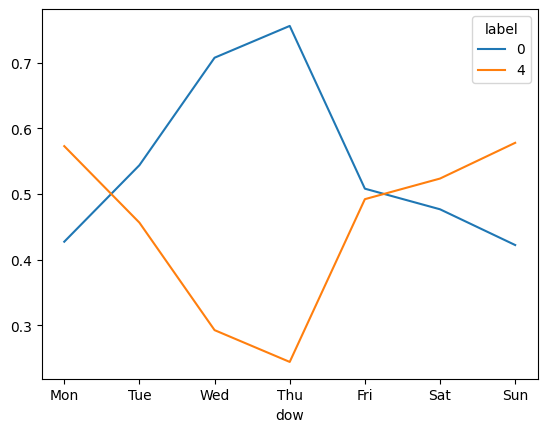

In [ ]:
temporal_dow.transpose().plot()

# 7. Pickling ! <a class="anchor" id="head-7"></a>

In [ ]:
import pickle

In [ ]:
# Saving a python object to disk
pickle.dump(classifier, open("classifier.p", "wb"))

In [ ]:
# Loading a python object from disk
classifier = pickle.load(open("classifier.p", "rb"))

In [ ]:
pickle.dump(model_clean_data,open("model_clean_data.p","wb"))

In [ ]:
import pickle

# Load the model from the pickle file
with open('model_clean_data.p', 'rb') as f:
    predict_custom_tweet_sentiment = pickle.load(f)


